In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf


In [2]:
# Fetch historical yield curve data from yfinance
ticker = "^TNX"  # 10-year US Treasury yield
data = yf.download(ticker, start="2000-01-01", end="2024-01-01")
data = data[['Close']].rename(columns={'Close': 'interest_rate'})

# Display the first few rows of the data
print(data.head())


[*********************100%***********************]  1 of 1 completed

Price                     interest_rate
Ticker                             ^TNX
Date                                   
2000-01-03 00:00:00+00:00         6.548
2000-01-04 00:00:00+00:00         6.485
2000-01-05 00:00:00+00:00         6.599
2000-01-06 00:00:00+00:00         6.549
2000-01-07 00:00:00+00:00         6.504


In [3]:
data = data.dropna()  # Drop rows with missing values

# Display the first few rows of the cleaned data
print(data.head())


Price                     interest_rate
Ticker                             ^TNX
Date                                   
2000-01-03 00:00:00+00:00         6.548
2000-01-04 00:00:00+00:00         6.485
2000-01-05 00:00:00+00:00         6.599
2000-01-06 00:00:00+00:00         6.549
2000-01-07 00:00:00+00:00         6.504


In [4]:
# Extract interest rates from the data
rates = data['interest_rate'].values

# Define the log-likelihood function
def vasicek_log_likelihood(params, rates):
    a, b, sigma = params
    n = len(rates)
    dt = 1  # Assuming daily data
    likelihood = 0
    for i in range(1, n):
        dr = rates[i] - rates[i-1]
        mean = a * (b - rates[i-1]) * dt
        variance = sigma**2 * dt
        likelihood += -0.5 * (np.log(2 * np.pi * variance) + (dr - mean)**2 / variance)
    return -likelihood

# Initial parameter guesses
initial_params = [0.1, 0.05, 0.01]

# Optimize the log-likelihood function
result = minimize(vasicek_log_likelihood, initial_params, args=(rates,))
a, b, sigma = result.x

print(f'Estimated parameters: a={a}, b={b}, sigma={sigma}')


Estimated parameters: a=-1.2137329584625999e-06, b=364.1284883086324, sigma=0.05815123615146964


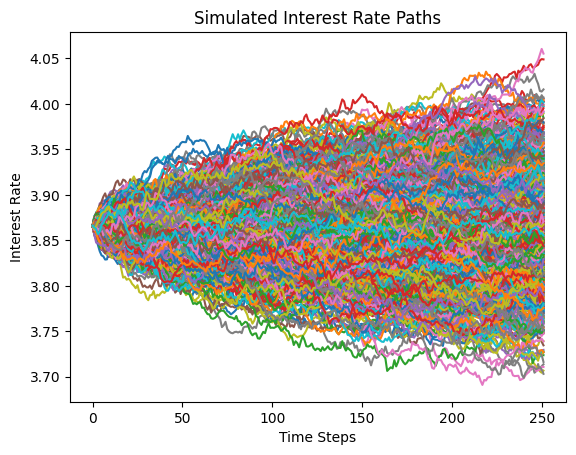

In [5]:
def simulate_vasicek_paths(a, b, sigma, r0, T, dt, n_paths):
    n_steps = int(T / dt)
    paths = np.zeros((n_steps, n_paths))
    paths[0] = r0
    for t in range(1, n_steps):
        dt_sqrt = np.sqrt(dt)
        dW = np.random.normal(0, dt_sqrt, n_paths)
        paths[t] = paths[t-1] + a * (b - paths[t-1]) * dt + sigma * dW
    return paths

# Parameters
r0 = rates[-1]  # Starting rate
T = 1  # 1 year
dt = 1/252  # Daily steps
n_paths = 1000  # Number of simulated paths

# Simulate paths
simulated_paths = simulate_vasicek_paths(a, b, sigma, r0, T, dt, n_paths)

# Plot the simulated paths
plt.plot(simulated_paths)
plt.xlabel('Time Steps')
plt.ylabel('Interest Rate')
plt.title('Simulated Interest Rate Paths')
plt.show()


In [6]:
def bond_price(face_value, coupon_rate, maturity, interest_rates):
    prices = []
    for rates in interest_rates.T:
        price = 0
        for t in range(1, maturity + 1):
            price += coupon_rate * face_value / (1 + rates[t-1])**t
        price += face_value / (1 + rates[maturity-1])**maturity
        prices.append(price)
    return np.array(prices)

# Example bond parameters
face_value = 1000
coupon_rate = 0.05
maturity = 5  # 5 years

# Calculate bond prices
bond_prices = bond_price(face_value, coupon_rate, maturity, simulated_paths)

# Display the first few bond prices
print(bond_prices[:5])


[13.29901731 13.28733505 13.28698749 13.28585485 13.29037682]
